In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Дана база данных компании Лондона, которая занимается арендой велосипедов

### Описание данных
timestamp – дата и время (точность до часа)  
cnt – количество аренд велосипедов за этот час  
t1 – температура, в С  
t2 – температура "ощущается как", в С   
hum – влажность (%)  
wind_speed – скорость ветра, км/ч  

weather_code – погодные условия:  
1 – ясно (SKC)  
2 – преимущественно ясно / встречаются отдельные облака (SCT)  
3 – облачно / значительные облака (BKN)  
4 – пасмурно (OVC)  
7 – небольшой дождь Rain/ light Rain shower/ Light rain   
10 – дождь с грозой  
26 – снегопад  
94 – ледяной туман (да, такое бывает!)  
isholiday – является ли день праздником (1 – праздник, 0 – нет)  
isweekend –  является ли день выходным (1 – выходной, 0 – нет)  
season – метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима)  

In [2]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-b-dzhumaeva-37/stat/3/london.csv', parse_dates=['timestamp'])

In [3]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [53]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [54]:
# приведем данные к нужным типам, в новое поле date - поместим данные из timestamp без подробностей о времени
df['date']=df.timestamp.apply(lambda s: s[:-9])
df.timestamp=pd.to_datetime(df.timestamp)
df.is_holiday=df.is_holiday.astype('int')
df.is_weekend=df.is_weekend.astype('int')
df.season=df.season.astype('int')
df.weather_code=df.weather_code.astype('int')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,date
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3,0,1,3,2015-01-04
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1,0,1,3,2015-01-04
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1,0,1,3,2015-01-04
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1,0,1,3,2015-01-04
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1,0,1,3,2015-01-04


In [55]:
df.isna().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
date            0
dtype: int64

### 1. Построим график по числу поездок по дате и времени
по оси x – дата (timestamp)   
по оси y – число поездок (cnt)

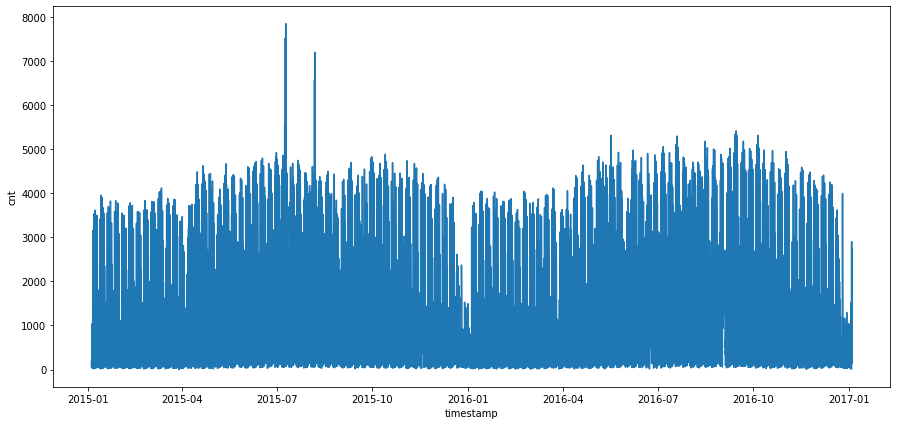

In [56]:
a=df.groupby('timestamp', as_index=False).agg({'cnt':'sum'})
plt.figure(figsize=(15, 7))
sns.lineplot(x='timestamp', y='cnt', data=a)

По таким данным очень сложно что-либо понять, необходимо преобразовать данные. Для этого используем resample. Этот метод позволяет преобразовать данные и применить к какому-либо столбцу другой метод (напр. sum). Так можно рассчитать показатели, например, за весь день или месяц, имея данные с точностью до минут.

### 2. Агрегируем число поездок по дням и визуализируем результат

In [57]:
df=df.set_index('timestamp')

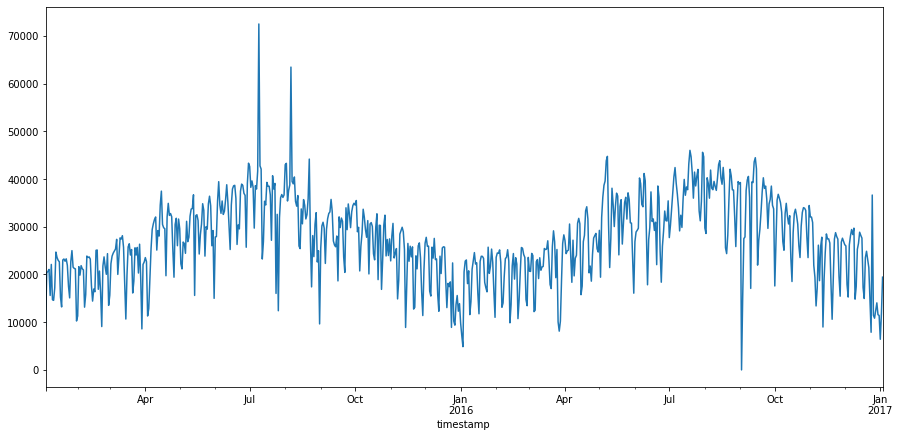

In [58]:
plt.figure(figsize=(15, 7))
df.resample(rule='D').cnt.sum().plot()  # считаем сумму аренд по дням

### Так уже можно сделать некоторые выводы:
1. Встречаются как очень резкие скачки числа аренд, так и падения
2. Максимальное число аренд за день составляет более 70 000
3. Зимой число аренд меньше, чем летом

### 3. Проверим, что же могло произойти в дни скачков аренд.
Для этого:

1. Сначала посчитаем скользящее среднее, чтобы сгладить ряд
2. Далее – разницу между наблюдаемыми и сглаженными значениями
3. Определим верхние и нижние границы 99% доверительного интервала 

In [72]:
# Посчитаем скользящее среднее с окном 3
# Посчитаем разницу между наблюдаемыми и подсчитанными значениями
# Расчитаем стандартное отклонение
df_by_day=pd.DataFrame(df.resample(rule='D').cnt.sum())
df_by_day['roll']=df_by_day.cnt.rolling(3).mean()
df_by_day['dif']=df_by_day.cnt-df_by_day.roll
df_by_day.head()

,cnt,roll,dif
timestamp,,,
2015-01-04,9234,NaN,NaN
2015-01-05,20372,NaN,NaN
2015-01-06,20613,16739.666667,3873.333333
2015-01-07,21064,20683.000000,381.000000
2015-01-08,15601,19092.666667,-3491.666667


In [73]:
mean_std=np.std(df_by_day.dif)

In [70]:
mean_std

4558.58664111794

In [ ]:
# Теперь определим границы интервалов. Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать
# следующие объекты:
# upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
# lower_bound – нижняя граница; вычитаем 2.576∗std

In [74]:
df_by_day['upper_bound']=df_by_day.roll+2.576*mean_std
df_by_day['lower_bound']=df_by_day.roll-2.576*mean_std
df_by_day.head()

,cnt,roll,dif,upper_bound,lower_bound
timestamp,,,,,
2015-01-04,9234,NaN,NaN,NaN,NaN
2015-01-05,20372,NaN,NaN,NaN,NaN
2015-01-06,20613,16739.666667,3873.333333,28482.585854,4996.747479
2015-01-07,21064,20683.000000,381.000000,32425.919188,8940.080812
2015-01-08,15601,19092.666667,-3491.666667,30835.585854,7349.747479


In [ ]:
# Изучим аномально высокие значения! 
# Выведем наблюдения, для которых наблюдаемые значения оказались больше верхней границы 99% доверительного интервала.
# В какой день значение числа аренд оказалось наибольшим?

In [77]:
df_by_day.query('cnt>upper_bound')

,cnt,roll,dif,upper_bound,lower_bound
timestamp,,,,,
2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


 2015-07-09 дата, когда число аренд наибольшее, среди дней по количеству аренд выше верхней границы. Поиск по сети выдает, что в этот день в Лондоне была забастовка метро.

In [79]:
df_by_day.query('cnt < lower_bound')

,cnt,roll,dif,upper_bound,lower_bound
timestamp,,,,,
2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812


2016-09-02 - дата, когда число аренд наименьшее среди дней по количеству аренд ниже нижней границы доверительного интервала. Значение 0 - подозрительное. По поиску в сети не было найдено каких-либо аномалий в погоде, проведение каких-либо мероприятий или экстренных ситуаций. Делаем вывод, что это ошибка данных.